In [4]:
import os
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] 
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
CLEAN_DIR = DATA_DIR / "clean"
ENRICHED_DIR = DATA_DIR / "enriched"



In [5]:
from src.data_enrichment import get_features
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[(df_feats['season_end_year'] != 2025) & (df_feats['season_end_year'] != 2026)]

c:\Users\leodo\OneDrive\Escritorio\machine learning\Machine-learning\src\data_enrichment.py:301: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from statsmodels.tsa.stattools import adfuller


stationary test over performance variables 

In [9]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",   
]
adf_results = []

for col in safe_cols:
    if col in df_feats.columns:
        # eliminar NA
        series = df_feats[col].dropna()
        if len(series) > 1:  # ADF necesita al menos 2 valores
            result = adfuller(series)
            adf_results.append({
                "variable": col,
                "adf_statistic": result[0],
                "p_value": result[1],
                "stationary": result[1] < 0.05
            })

adf_df = pd.DataFrame(adf_results)
print(adf_df)


               variable  adf_statistic  p_value  stationary
0                 goals     -57.732212      0.0        True
1               assists     -60.274176      0.0        True
2         penalty_goals     -86.688423      0.0        True
3             own_goals     -86.485108      0.0        True
4          yellow_cards     -37.732079      0.0        True
5   second_yellow_cards     -39.581014      0.0        True
6      direct_red_cards     -87.110678      0.0        True
7        minutes_played     -84.255123      0.0        True
8        goals_conceded     -65.605995      0.0        True
9          clean_sheets     -53.281454      0.0        True
10          nb_on_pitch     -37.075579      0.0        True
11          nb_in_group     -26.460059      0.0        True
12             subed_in     -70.543130      0.0        True
13            subed_out     -75.494757      0.0        True
14               height     -64.868645      0.0        True
15       matches_played     -37.115940  

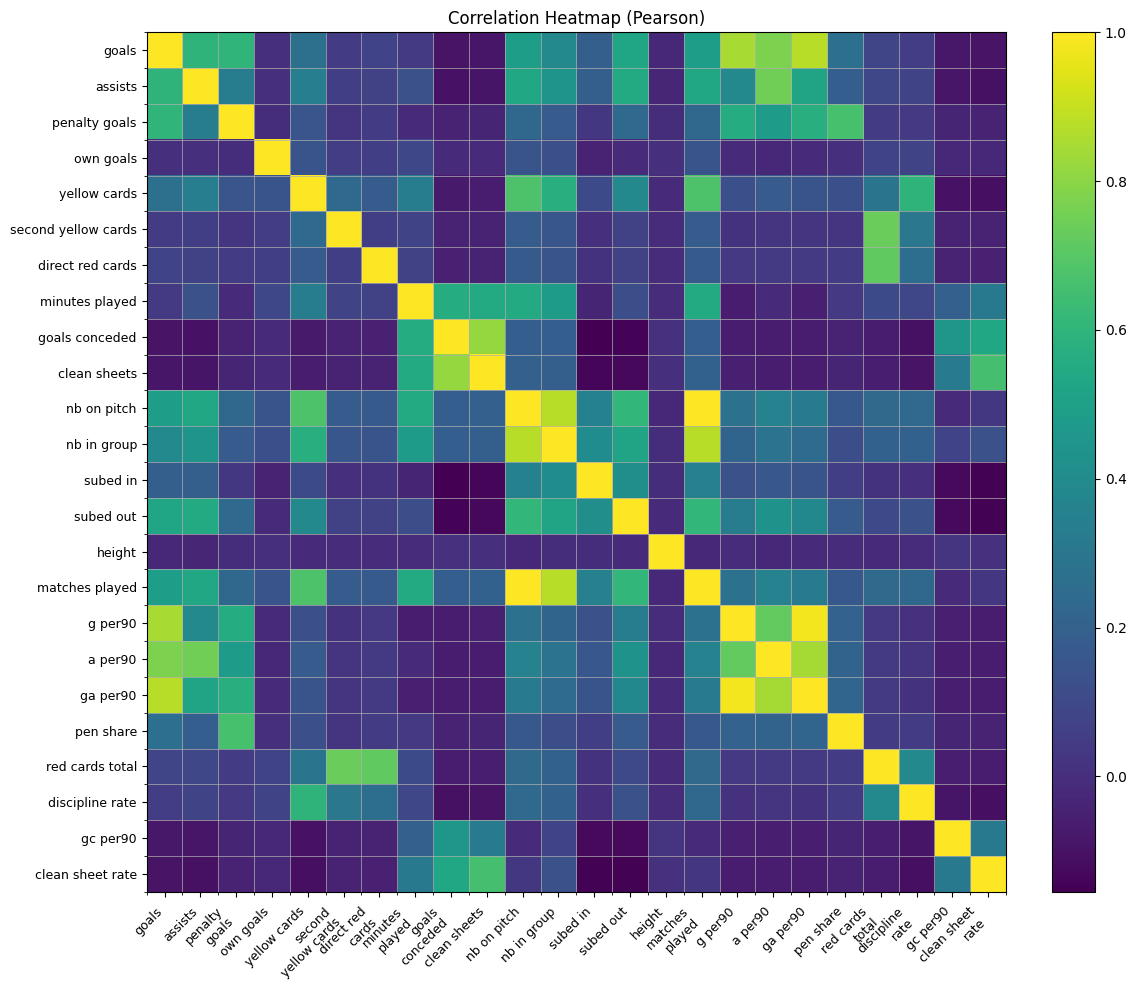

In [21]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",
    
]

X = df_feats[safe_cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = X.corr(method="pearson")

# wrap labels to multiple lines (split underscores + wrap to width)
def wrap_label(s, width=12):
    s = s.replace("_", " ")
    return "\n".join(textwrap.wrap(s, width=width))

xlabels = [wrap_label(c, width=12) for c in corr.columns]
ylabels = [c.replace("_", " ") for c in corr.index]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, interpolation="nearest", aspect="equal")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (Pearson)")

n = len(corr.columns)
ticks = np.arange(n)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(xlabels, rotation=45, ha="right", va="top")
ax.set_yticklabels(ylabels)

# add light gridlines between cells
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
ax.grid(which="minor", linewidth=0.5)
ax.tick_params(axis="x", labelsize=9, pad=6)
ax.tick_params(axis="y", labelsize=9)

# give bottom extra space for the wrapped labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


In [22]:
def drop_highly_correlated(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop, errors="ignore"), to_drop

X = df_feats[safe_cols].select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).dropna()
X_filtered, dropped_cols = drop_highly_correlated(X, threshold=0.8)

print(f"Dropped {len(dropped_cols)} highly correlated features:")
print(dropped_cols)

Dropped 5 highly correlated features:
['clean_sheets', 'nb_in_group', 'matches_played', 'g_per90', 'ga_per90']


Having the ingenierd features added, the only one that could be interest to tests are the deltas, z is just the standarization between leagues, lags just account past season and ¿delta is the diference so we may test stacionarity there?

In [11]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

def adf_test_deltas_with_flag(df, delta_cols, min_n=5, threshold=0.5):
    """
    Perform ADF test on delta columns per player.
    Adds a 'stationary' column: True if share_stationary > threshold.
    """
    out = {}
    gdf = df.sort_values("season_end_year").groupby("player_id")
    
    for col in delta_cols:
        pvals = []
        for pid, g in gdf:
            series = g[col].dropna()
            if len(series) >= min_n and series.nunique() > 1:
                try:
                    pvals.append(adfuller(series)[1])  # store p-value
                except Exception:
                    pass
        if pvals:
            out[col] = np.array(pvals)
    
    # Build summary
    rows = []
    for col, arr in out.items():
        share_stationary = (arr < 0.05).mean()  # proportion of players stationary
        rows.append({
            "metric": col,
            "n_players_tested": len(arr),
            "share_stationary": share_stationary,
            "stationary": share_stationary > threshold  # True if majority stationary
        })
    
    summary_df = pd.DataFrame(rows).sort_values("share_stationary", ascending=False).reset_index(drop=True)
    return summary_df


In [ ]:
delta_cols = [
    "ga_per90_z_delta", "g_per90_z_delta", "a_per90_z_delta", "gc_per90_z_delta",
    "clean_sheet_rate_z_delta", "discipline_rate_z_delta", "pen_share_z_delta",
    "minutes_played_z_delta", "matches_played_z_delta"
]

delta_summary = adf_test_deltas_with_flag(df_feats, delta_cols)
print(delta_summary)


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_player_metric(df, player_id, metric, season_col='season_name', name_col='player_name'):
    """
    Plots a time series for a specific player and metric.
    Handles seasons in '22/23' string format and plots original, lag1, and delta series if available.
    Includes player name in the title if available.
    """
    df_player = df[df['player_id'] == player_id].copy()
    
    # Get player name (if column exists)
    player_name = df_player[name_col].iloc[0] if name_col in df_player.columns else str(player_id)
    
    # Ensure the season column is string
    df_player[season_col] = df_player[season_col].astype(str)
    
    # Convert season strings like '22/23' to numeric
    df_player['season_num'] = pd.to_numeric(
        df_player[season_col].str.split('/').str[0], errors='coerce'
    ) + 2000
    
    # Ensure metric is numeric
    df_player[metric] = pd.to_numeric(df_player[metric], errors='coerce')
    
    # Drop invalid rows
    df_player = df_player.dropna(subset=['season_num', metric])
    df_player = df_player.sort_values('season_num')

    plt.figure(figsize=(10,6))
    plt.plot(df_player['season_num'], df_player[metric], marker='o', linestyle='-', label='Original')

    # Plot lag1 if exists
    lag_col = f"{metric}_lag1"
    if lag_col in df_player.columns:
        df_player[lag_col] = pd.to_numeric(df_player[lag_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[lag_col], marker='x', linestyle='--', label='Lag1')

    # Plot delta if exists
    delta_col = f"{metric}_delta"
    if delta_col in df_player.columns:
        df_player[delta_col] = pd.to_numeric(df_player[delta_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[delta_col], marker='s', linestyle=':', label='Delta')

    plt.title(f"{metric} over time for {player_name} (ID: {player_id})")
    plt.xlabel("Season (start year)")
    plt.ylabel(metric)
    plt.xticks(df_player['season_num'].astype(int))  # force numeric ticks
    plt.grid(True)
    plt.legend()
    plt.show()


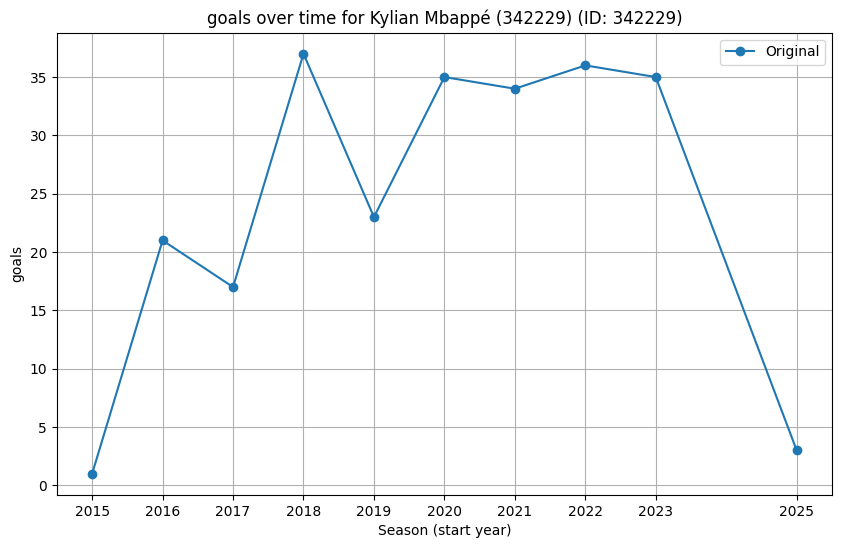

In [13]:
plot_player_metric(df_feats, player_id="342229", metric='goals')
